# Testing problem

<center>The PDE of the general type is</center>
<center>$\nabla\cdot(-c\nabla u)=f$</center>
<center>$-\mathbf{n}\cdot(-c\nabla u)=g-qu$ on $S_2$</center>
<center>$u=s$ on $S_1$</center>
<br>
<center>Consider the 1D Poisson-Boltzmann (PB) equaion with mixed boundary condition</center>
<center>$c=\varepsilon_0\varepsilon_a$ with $\varepsilon_a=78.5$</center>
<center>$f=-2zeC^\infty_\pm\sinh[ue/(kT)]$ with ion valence $z=1$</center>
<center>and</center>
<center>$-\mathbf{n}\cdot\nabla(-\varepsilon_0\varepsilon_a u)=-\Sigma_d$ at $r=a$ with $\Sigma_d=0.01,a=5\times10^{-9}$</center>
<center>$u=0$ at $r=\infty$</center>
<br>
<center>Define $\kappa=[2z^2e^2C^\infty_\pm/(\varepsilon_0\varepsilon_a k_BT)]$ the inverse Debye screening length</center>
<center>The PB equation becomes</center>
<br>
<center>$$\nabla\cdot(-\nabla u)=-\kappa^2\frac{k_BT}{ze}\sinh\big(\frac{zeu}{k_BT}\big)$$</center>
<br>
<center>And the linear PB equation is</center>
<center>$\nabla\cdot(-\nabla u)=-\kappa^2u$</center>
<br>
<center>Analytical solution of the 1D linear PB equation for spherical coordinate is</center>
<br>
<center>$$u=\frac{\Sigma_d}{(\kappa+a^{-1})\varepsilon_0\varepsilon_a} a\frac{\exp[\kappa(a-r)]}{r}$$</center>


# Initialize main functions

In [1]:
#usage: python main.py
#output: solution to the Poission-Boltzmann equation

import numpy as np
import numpy.matlib
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import time

#Domain discretization and required variables (Jin 2002 P167)
#The volume V is subdivided into a number tetrahedral elements and
#the surface is broken into a number of triangular elements
#(1) array n(i,e) of size 4xM
#The element numbers and node numbers can be related by a 4xM integer array n(i,e)
#where i=1,2,3,4, e=1,2,3,...,M, and M denotes the total number of volume elements
#The array n(i,e) stores the global node number of the i^th node of the e^th element
#(2) vector nd(i) of length N1
#To facilitate imposition of the Dirichlet boundary condition on surface S1
#the integer vector nd(i) stores the global node number of the nodes that reside on
#the surface S1, where i=1,2,3,...,N1, and N1 denotes the total number of such nodes
#(3) array ns(i,e) of size 3xMs - not defined yet
#For the treatment of the boundary condition of the third kind on surface S2
#the 3xMs integer array ns(i,e) holds information related to the surface triangular
#elements and their associated nodes residing on the surface S2, where i=1,2,3,
#e=1,2,3,...,Ms,and Ms is the total number of surface triangular elements on S2
#The array ns(i,e) stores the global number of the i^th node of the s^th elements
#(4) Other data that are needed include the coordinates of each node, the value of
#PDE coefficients for each volume elements, the prescribed value of u for each node
#on S1, and the coefficients of the boundary condition of the third kind
#for each surface triangular elements on S2

#Useful links
#(1) Quadrature on tetrahedra
#https://www.cfd-online.com/Wiki/Code:_Quadrature_on_Tetrahedra
#(2) Quadpy
#https://github.com/nschloe/quadpy
#(3) Shape function
#https://www.iue.tuwien.ac.at/phd/orio/node48.html
#(4) Another document about reference tetrahedra
#https://people.sc.fsu.edu/~jburkardt/presentations/cg_lab_fem_basis_tetrahedron.pdf
#(5) COMSOL for static nonlinear finite element problems
#https://www.comsol.com/blogs/solving-nonlinear-static-finite-element-problems/
#(6) Set values in Python sparse matrix
#http://seanlaw.github.io/2019/02/27/set-values-in-sparse-matrix/
#(7) Molarity unit conversion
#http://web.pdx.edu/~justc/courses/RecombDNALab/MolBioWorksheet.pdf
#(8) Why stiffness matrix is non-symmetric
#https://www.quora.com/Why-is-the-stiffness-matrix-in-the-finite-element-method-symmetric
#(9) Contour plot of irregularly spaced data
#https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html
#(10) Three-Dimensional Plotting in Matplotlib
#https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

#set physical constants and parameters
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kB=1.381e-23 #Boltzmann's constant [J/K]
kA=6.022e23 #Avogadro constant [1/mol]

def set_globvars(infile):
    global nodes,elements,faces,midpoints #mesh variables
    global node_flags,zones,face_flags #variables for performing tests
    global mask_e,mask_d,mask_s #boolean element/node/face indicies for volume/S1/S2
    global cx,cy,cz #PDE coefficients for scalar field
    global alphax,alphay,alphaz #PDE coefficients for scalar field
    global betax,betay,betaz #PDE coefficients for scalar field
    global gammax,gammay,gammaz #PDE coefficients for scalar field
    global a,f,g,q,s #PDE coefficients for scalar field
    global cx3,cy3,cz3 #PDE coefficients for vector field
    global alphax3,alphay3,alphaz3 #PDE coefficients for vector field
    global betax3,betay3,betaz3 #PDE coefficients for vector field
    global gammax3,gammay3,gammaz3 #PDE coefficients for vector field
    global a3,f3,g3,q3,s3 #PDE coefficients for vector field
    global rel_perm,tK,cinf,zval #physical properties
    global kd #scaling coefficients for distance
    
    #load pde coefficients
    print('Loading %s'%infile)
    print('')
    data=np.load(infile)
    nodes=data['nodes']
    elements=data['elements']
    faces=data['faces']
    
    node_flags=data['node_flags']
    zones=data['zones']
    face_flags=data['face_flags']
    
    mask_e=data['mask_e'] #computational element indices
    mask_d=data['mask_d'] #node indicies on Dirichlet boundary (S1)
    mask_s=data['mask_s'] #surface element indicies on the boundary of the third kind (S2)
    
    cx=data['cx']
    cy=data['cy']
    cz=data['cz']
    alphax=data['alphax']
    alphay=data['alphay']
    alphaz=data['alphaz']
    betax=data['betax']
    betay=data['betay']
    betaz=data['betaz']
    gammax=data['gammax']
    gammay=data['gammay']
    gammaz=data['gammaz']
    a=data['a']
    f=data['f']
    g=data['g']
    q=data['q']
    s=data['s']
    
    cx3=data['cx3']
    cy3=data['cy3']
    cz3=data['cz3']
    alphax3=data['alphax3']
    alphay3=data['alphay3']
    alphaz3=data['alphaz3']
    betax3=data['betax3']
    betay3=data['betay3']
    betaz3=data['betaz3']
    gammax3=data['gammax3']
    gammay3=data['gammay3']
    gammaz3=data['gammaz3']
    a3=data['a3']
    f3=data['f3']
    g3=data['g3']
    q3=data['q3']
    s3=data['s3']
    
    rel_perm=data['rel_perm']
    tK=data['tK']
    cinf=data['cinf']
    zval=data['zval']
    
    #compute middle point of each elements (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=.25*sum(nodes[elements[i,:],j])
        
    nind_e=np.unique(elements[mask_e].flatten(order='C'))
    print('THE NUMBER OF COMPUTATIONAL NODES IS:',len(nind_e))
    print('THE NUMBER OF COMPUTATIONAL ELEMENTS IS:',np.count_nonzero(mask_e))
    print('THE NUMBER OF NODES ON S1 IS:',np.count_nonzero(mask_d))
    print('THE NUMBER OF ELEMENTS ON S2 IS:',np.count_nonzero(mask_s))
    print('')
    
    print('Scale the PDE equation for distance')
    debye_len=np.sqrt(rel_perm*perm0*kB*tK/2/zval**2/echarge**2/kA/cinf)
    kd=10**(-round(np.log10(debye_len))) #to be determined from debye length
    nodes=nodes*kd
    
    alphax=alphax/kd
    alphay=alphay/kd
    alphaz=alphaz/kd
    
    betax=betax/kd
    betay=betay/kd
    betaz=betaz/kd
    
    gammax=gammax/kd
    gammay=gammay/kd
    gammaz=gammaz/kd
    
    #make sure a,f,g,q were scaled by perm0 before
    #actually all PDE coefficients should be scaled by perm0
    #scale everything in main.py in later modifications
    #by adding an option scale_perm0 or not in build_pde.py
    #then call scale_pde function in main.py after set_globvars
    a=f/kd/kd
    f=f/kd/kd
    
    g=g/kd
    q=q/kd #not really tested this q
    
    return

def solve_u(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    u=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    return u

def output_u(nodes,u,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]*kd
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,5]=u[ind]

    outfile=srvfile+'.out'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',
               fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e')
    print('')
    return output

def build_a(u):
    #input u on nodes output a on nodes
    #a_nodes=2*echarge**2*cinf/kB/tK*np.cosh(echarge*u/kB/tK)
    
    #Given tK=293, un=39.591*zval*u
    #Given tK=293, zval=1, u=1, np.cosh(un)=7.822e16
    #Given tK=293, a=7.639e6*zval*cinf*np.cosh(un)
    #Given tK=293, zval=1, u=1, cinf=1, a=5.975e23
    ze=zval*echarge #ion valence times elementary charge
    un=ze*u/kB/tK #normalized potential
    a=2*ze**2*kA*cinf/kB/tK*np.cosh(un)/perm0/kd/kd #scaled by perm0
        
    return a

def build_f(u):
    #input u on nodes output f on nodes
    #f_nodes=-2*echarge*cinf*(np.sinh(echarge*u/kB/tK)-np.cosh(echarge*u/kB/tK)*echarge*u/kB/tK)
    
    #Given tK=293, un=39.591*zval*u
    #Given tK=293, zval=1, u=1, np.cosh(un)=7.822e16
    #Given tK=293, zval=1, u=1, np.sinh(un)=7.822e16
    #Given tK=293, f=-1.930e5*zval*cinf*(np.sinh(un)-np.cosh(un)*un)
    #Given tK=293, zval=1, u=1, cinf=1, f=-5.824e23
    ze=zval*echarge #ion valence times elementary charge
    un=ze*u/kB/tK #normalized potential
    f=-2*ze*kA*cinf*(np.sinh(un)-np.cosh(un)*un)/perm0/kd/kd #scaled by perm0
        
    return f

# #compute ion concentration in the bulk electrolyte
# def compute_conc(u):
    
#     return

#compute gradient of scalar field u (need to be verified)
def gradient(xn,yn,zn,u):
    du=np.zeros(3) #du is constant inside an element
    Je=np.zeros((4,4))
    
    Je[0,:]=1
    Je[1,:]=xn #x-coordinates of four nodes in an element
    Je[2,:]=yn
    Je[3,:]=zn
    invJe=np.linalg.inv(Je)
    
    du[0]=np.sum(u[:]*invJe[:,1])
    du[1]=np.sum(u[:]*invJe[:,2])
    du[2]=np.sum(u[:]*invJe[:,3])
    
    return du

#evaluate basis functions at (xr,yr,zr) given tetrahedra nodes (xn,yn,zn) (not tested or used so far)
def basis(xn,yn,zn,xr,yr,zr):
    Je=np.zeros((4,4))
    
    Je[0,:]=1
    Je[1,:]=xn #x-coordinates of four nodes in an element
    Je[2,:]=yn
    Je[3,:]=zn
    invJe=np.linalg.inv(Je)
    Ne=invJe.dot([1,xr,yr,zr])
    
    return Ne

#build system of equations for vector field (not tested so far)
def build_system3(nodes,elements,faces,cx3,cy3,cz3,a3,f3,g3,q3,s3):
    mask3_d=np.matlib.repmat(mask_d,3,1).flatten(order='F') #row major storage
    mask3_notd=~mask3_d
    
    nind_d=np.where(mask_d)[0]
    nind_notd=np.where(~mask_d)[0]
    
    face_s=faces[mask_s,:]
    gs3=g3[mask_s,:]
    qs3=q3[mask_s,:,:]
    sd3=s3[mask_d,:]
    
    nnode=len(nodes)
    nelem=len(elements)
    nd=len(nind_d)
    nnotd=len(nind_notd)
    ns=len(face_s)

    nt=(nelem*16+ns*9)*9 #three components/unknowns per node
    I3=np.zeros(nt) #holds the row indices
    J3=np.zeros(nt) #holds the col indices
    X3=np.zeros(nt) #holds the element values
    X3_notd=np.zeros(nt) #nonzero for nodes not on Dirichlet boundary
    nt=0
    b3=np.zeros(nnode*3)
    b3_notd=np.zeros(nnotd*3)
    
    print('Assembling the system of equations')
    start=time.time()
    #for i in range(nelem):
    for i in range(1):
        sctr=elements[i,:4]
        sctr3=np.zeros(12,dtype=int)
        for j in range(4):
            sctr3[j*3:(j+1)*3]=sctr[j]*3+np.arange(3)
        
        xn=nodes[sctr,0]
        yn=nodes[sctr,1]
        zn=nodes[sctr,2]
        Ke3,be3=build_Ke3(xn,yn,zn,cx3[i,:,:],cy3[i,:,:],cz3[i,:,:],a3[i,:,:],f3[i,:])
        Ke3_notd=np.reshape(mask3_notd[sctr3].astype(int),(4*3,1))
        nt=nt+16*9
            
        #I holds the global row indices of Ke_ij, e.g. [[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]
        #J holds the global col indices of Ke_ij, e.g. [[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
        #X holds the entries of Ke_ij
        I3[nt-16*9:nt]=np.matlib.repmat(sctr3,4*3,1).flatten(order='F') #row indcies grow slower
        J3[nt-16*9:nt]=np.matlib.repmat(sctr3,4*3,1).flatten(order='C') #col indices grow faster
        X3[nt-16*9:nt]=Ke3.flatten(order='C') #stored in row major and Ke3_ij!=Ke3_ji
        X3_notd[nt-16*9:nt]=Ke3_notd.dot(Ke3_notd.T).flatten(order='C') #stored in row major
        b3[sctr3]=b3[sctr3]+be3
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    for i in range(ns):
        sctr=face_s[i,:3]
        sctr3=np.zeros(9,dtype=int)
        for j in range(3):
            sctr3[j*3:(j+1)*3]=sctr[j]*3+np.arange(3)
        
        xn=nodes[sctr,0]
        yn=nodes[sctr,1]
        zn=nodes[sctr,2]
        Ks3,bs3=build_Ks3(xn,yn,zn,gs3[i,:],qs3[i,:,:])
        Ks3_notd=np.reshape(mask3_notd[sctr3].astype(int),(3*3,1))
        nt=nt+9*9
        
        #I holds the global row indices of Ks_ij, e.g. [[1,1,1],[2,2,2],[3,3,3]]
        #J holds the global col indices of Ks_ij, e.g. [[1,2,3],[1,2,3],[1,2,3]]
        #X holds the entries of Ks_ij
        I3[nt-9*9:nt]=np.matlib.repmat(sctr3,3*3,1).flatten(order='F') #row indices grow slower
        J3[nt-9*9:nt]=np.matlib.repmat(sctr3,3*3,1).flatten(order='C') #col indices grow faster
        X3[nt-9*9:nt]=Ks3.flatten(order='C') #stored in row major and Ks3_ij!=Ks3_ji
        X3_notd[nt-9*9:nt]=Ks3_notd.dot(Ks3_notd.T).flatten(order='C') #stored in row major
        b3[sctr3]=b3[sctr3]+bs3
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    #build matrix K using I,J,X
    K3=csr_matrix((X3,(I3,J3)),shape=(nnode*3,nnode*3))
    K3_notd=csr_matrix((X3_notd,(I3,J3)),shape=(nnode*3,nnode*3))
    K3_notd=csr_matrix.sign(K3_notd)
    
    start=time.time()
    print('Incoorprating the Dirichlet boundary condition')
    sd3=sd3.flatten(order='C')
    b3[mask3_d]=sd3

    for i in range(nnotd):
        sctr=nind_notd[i]
        #b[sctr]=b[sctr]-K[sctr,mask_d].dot(s)
        for j in range(3):
            b3_notd[i*3+j]=K3[sctr*3+j,mask3_d].dot(sd3)
            b3[sctr*3+j]=b3[sctr*3+j]-b3_notd[i*3+j]
        
    K3=K3.multiply(K3_notd) #nonzero entries i.e. K3.getnnz() get reduced
    nt=K3.getnnz()+nd*3
    I3=np.zeros(nt) #holds the row indices
    J3=np.zeros(nt) #holds the col indices
    X3=np.zeros(nt) #holds the element values

    I3[:K3.getnnz()]=K3.nonzero()[0]
    J3[:K3.getnnz()]=K3.nonzero()[1]
    X3[:K3.getnnz()]=K3.data
    
    sctr3=np.zeros(nd*3)
    sctr3[0::3]=nind_d*3
    sctr3[1::3]=nind_d*3+1
    sctr3[2::3]=nind_d*3+2
    
    I3[K3.getnnz():]=sctr3
    J3[K3.getnnz():]=sctr3
    X3[K3.getnnz():]=np.ones(nd*3)
    K3=csr_matrix((X3,(I3,J3)),shape=(nnode*3,nnode*3))

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K3,b3,b3_notd

#compute Ke and be for vector field (not tested so far)
def build_Ke3(xn,yn,zn,cx3,cy3,cz3,a3,f3):
    Ke3=np.zeros((4*3,4*3))
    be3=np.zeros(4*3)
    #row3=np.zeros((4*3,4*3))
    #col3=np.zeros((4*3,4*3))
    Je=np.zeros((4,4)) #basis function does not change
    
    Je[0,:]=1
    Je[1,:]=xn #x-coordinates of four nodes in an element
    Je[2,:]=yn
    Je[3,:]=zn
    invJe=np.linalg.inv(Je)
    detJe=np.linalg.det(Je)
    vol=detJe/6
    
    #see Eq 5.20 and 5.21 (Jin 2002 P171) for Ke and be
    #Ke should be modified for nonzero betax/betay/betaz
    #Ke[i,j]=(cx*invJe[i,1]*invJe[j,1]+cy*invJe[i,2]*invJe[j,2]+
    #         cz*invJe[i,3]*invJe[j,3]+a*(1+delta_ij)/20)*vol
    #be[i]=f*vol/4
    for i in range(12):
        i1=int(i/3)
        k1=int(i)%3
        for j in range(12):
            j1=int(j/3)
            l1=int(j)%3
            #row3[i,j]=sctr[i1]*3+k1
            #col3[i,j]=sctr[j1]*3+l1
            
            tmp=1-np.abs(np.sign(i1-j1))
            Ke3[i,j]=(cx3[k1,l1]*invJe[i1,1]*invJe[j1,1]+cy3[k1,l1]*invJe[i1,2]*invJe[j1,2]+
                      cz3[k1,l1]*invJe[i1,3]*invJe[j1,3]+a3[k1,l1]*(1+tmp)/20)*vol
        be3[i]=f[k1]*vol/4
            
    return Ke3,be3

#compute Ks and bs for vector field (not tested so far)
def build_Ks3(xs,ys,zs,g3,q3):
    #modify this to accomodate matrix/vector PDE coefficients
    Ks3=np.zeros((3*3,3*3))
    bs3=np.zeros(3*3)
    #row3=np.zeros((3*3,3*3))
    #col3=np.zeros((3*3,3*3))
    
    a=[xs[1]-xs[0],ys[1]-ys[0],zs[1]-zs[0]]
    b=[xs[2]-xs[1],ys[2]-ys[1],zs[2]-zs[1]]
    c=np.cross(a,b)
    area=np.linalg.norm(c)/2
    
    #see Eq 5.32 and 5.33 (Jin 2002 P172) for Ks and bs
    #Ks[i,j]=q*(1+delta_ij)*area/12
    #bs[i]=g*area/3
    for i in range(9):
        i1=int(i/3)
        k1=int(i)%3
        for j in range(9):
            j1=int(j/3)
            l1=int(j)%3
            #row3[i,j]=sctr[i1]*3+k1
            #col3[i,j]=sctr[j1]*3+l1
            
            tmp=1-np.abs(np.sign(i1-j1))
            Ks3[i,j]=q3[k1,l1]*(1+tmp)*area/12
        bs3[i]=g3[k1]*area/3
        
    return Ks3,bs3

#build system of equations for scalar field
def build_system(nodes,elements,faces,cx,cy,cz,a,f,g,q,s):
    nind_e=np.unique(elements[mask_e].flatten(order='C'))
    nind_map_global_to_local=-np.ones(len(nodes),dtype=int)
    nind_map_global_to_local[nind_e]=np.arange(len(nind_e))
    
    node_e=nodes[nind_e,:]
    elem_e=nind_map_global_to_local[elements[mask_e,:]]
    face_s=nind_map_global_to_local[faces[mask_s,:]]
    
    nind_d=nind_map_global_to_local[np.where(mask_d)[0]]
    nind_notd=nind_map_global_to_local[np.where(~mask_d)[0]]
    
    #nflags_notd is a temporary variable to assist imposition of Dirichlet B.C
    #nonzero for nodes not on Dirichlet boundary nodes_e[nind_notd]
    nflags_notd=np.zeros(len(node_e),dtype=int)
    nflags_notd[nind_notd]=1
    
    cxe=cx[mask_e]
    cye=cy[mask_e]
    cze=cz[mask_e]
    
    #ae=a[mask_e]
    #fe=f[mask_e]
    anod=a[nind_e]
    fnod=f[nind_e]
    
    gs=g[mask_s]
    qs=q[mask_s]
    sd=s[mask_d]

    nnode=len(node_e)
    nelem=len(elem_e)
    nd=len(nind_d)
    nnotd=len(nind_notd)
    ns=len(face_s)
    
    #nt=nelem*16+ns*9+nnotd*nd*2
    nt=nelem*16+ns*9
    I=np.zeros(nt) #holds the row indices
    J=np.zeros(nt) #holds the col indices
    X=np.zeros(nt) #holds the element values
    X_notd=np.zeros(nt) #nonzero for nodes not on Dirichlet boundary
    nt=0
    b=np.zeros(nnode)
    b_notd=np.zeros(nnotd)
    
    print('Assembling the system of equations')
    start=time.time()
    for i in range(nelem):
        sctr=elem_e[i,:4]
        xn=node_e[sctr,0]
        yn=node_e[sctr,1]
        zn=node_e[sctr,2]
        Ke,be=build_Ke(xn,yn,zn,cxe[i],cye[i],cze[i],anod[sctr],fnod[sctr])
        Ke_notd=np.reshape(nflags_notd[sctr],(4,1))
        nt=nt+16
        
        #I holds the global row indices of Ke_ij, e.g. [[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]
        #J holds the global col indices of Ke_ij, e.g. [[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
        #X holds the entries of Ke_ij
        I[nt-16:nt]=np.matlib.repmat(sctr,4,1).flatten(order='F')
        J[nt-16:nt]=np.matlib.repmat(sctr,4,1).flatten(order='C')
        X[nt-16:nt]=Ke.flatten(order='C') #This oder is not important because Ke_ij=Ke_ji
        X_notd[nt-16:nt]=Ke_notd.dot(Ke_notd.T).flatten(order='C') #This order does not matter neither
        b[sctr]=b[sctr]+be
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    for i in range(ns):
        sctr=face_s[i,:3]
        xn=node_e[sctr,0]
        yn=node_e[sctr,1]
        zn=node_e[sctr,2]
        Ks,bs=build_Ks(xn,yn,zn,gs[i],qs[i])
        Ks_notd=np.reshape(nflags_notd[sctr],(3,1))
        nt=nt+9
        
        #I holds the global row indices of Ks_ij, e.g. [[1,1,1],[2,2,2],[3,3,3]]
        #J holds the global col indices of Ks_ij, e.g. [[1,2,3],[1,2,3],[1,2,3]]
        #X holds the entries of Ks_ij
        I[nt-9:nt]=np.matlib.repmat(sctr,3,1).flatten(order='F')
        J[nt-9:nt]=np.matlib.repmat(sctr,3,1).flatten(order='C')
        X[nt-9:nt]=Ks.flatten(order='C') #This order is not important because Ks_ij=Ks_ji
        X_notd[nt-9:nt]=Ks_notd.dot(Ks_notd.T).flatten(order='C') #This order does not matter neither
        b[sctr]=b[sctr]+bs
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    #build matrix K using I,J,X
    #remember to manipulate elements in K using boolean index
    K=csr_matrix((X,(I,J)),shape=(nnode,nnode))
    K_notd=csr_matrix((X_notd,(I,J)),shape=(nnode,nnode))
    K_notd=csr_matrix.sign(K_notd)
    
    start=time.time()
    print('Incoorprating the Dirichlet boundary condition')
    b[nind_d]=sd

    for i in range(nnotd):
        sctr=nind_notd[i]
        #b[sctr]=b[sctr]-K[sctr,nind_d].dot(sd)
        b_notd[i]=K[sctr,nind_d].dot(sd)
        b[sctr]=b[sctr]-b_notd[i]
        
    K=K.multiply(K_notd) #nonzero entries i.e. K.getnnz() get reduced
    nt=K.getnnz()+nd
    I=np.zeros(nt) #holds the row indices
    J=np.zeros(nt) #holds the col indices
    X=np.zeros(nt) #holds the element values

    I[:K.getnnz()]=K.nonzero()[0]
    J[:K.getnnz()]=K.nonzero()[1]
    X[:K.getnnz()]=K.data

    I[K.getnnz():]=nind_d
    J[K.getnnz():]=nind_d
    X[K.getnnz():]=np.ones(nd)
    K=csr_matrix((X,(I,J)),shape=(nnode,nnode))

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b,b_notd

#compute Ke and be for scalar field
def build_Ke(xn,yn,zn,cx,cy,cz,a,f):
    Ke=np.zeros((4,4))
    be=np.zeros(4)
    Je=np.zeros((4,4))
    
    Je[0,:]=1
    Je[1,:]=xn #x-coordinates of four nodes in an element
    Je[2,:]=yn
    Je[3,:]=zn
    invJe=np.linalg.inv(Je)
    detJe=np.linalg.det(Je)
    vol=detJe/6
    
    #see Eq 5.20 and 5.21 (Jin 2002 P171) for Ke and be
    #Ke should be modified in case of nonzero betax/betay/betaz
    for i in range(4):
        for j in range(4):
            tmp=1-np.abs(np.sign(i-j))
            Ke[i,j]=(cx*invJe[i,1]*invJe[j,1]+cy*invJe[i,2]*invJe[j,2]+
                     cz*invJe[i,3]*invJe[j,3]+a[j]*(1+tmp)/20)*vol
            be[i]=be[i]+f[j]*vol*(1+tmp)/20
    
    return Ke,be

#compute Ks and bs for scalar field
def build_Ks(xs,ys,zs,g,q):
    Ks=np.zeros((3,3))
    bs=np.zeros(3)
    
    a=[xs[1]-xs[0],ys[1]-ys[0],zs[1]-zs[0]]
    b=[xs[2]-xs[1],ys[2]-ys[1],zs[2]-zs[1]]
    c=np.cross(a,b)
    area=np.linalg.norm(c)/2
    
    #see Eq 5.32 and 5.33 (Jin 2002 P172) for Ks and bs
    for i in range(3):
        for j in range(3):
            tmp=1-np.abs(np.sign(i-j))
            Ks[i,:]=q*area*(1+tmp)/12
        bs[i]=g*area/3 #may need to be modified
        
    return Ks,bs

print('Done')

Done


# Run sphere example

In [2]:
set_globvars('sphere_s21.npz')
sigma_e=np.zeros(len(faces))
sigma_s=np.zeros(len(faces))
sigma_sign=np.zeros(len(faces))
u=np.zeros(len(nodes))
nind_e=np.unique(elements[mask_e].flatten(order='C'))

sigma_e[:]=g*kd*perm0 #true surface charges on S2
sigma_s[:]=0.01 #starting surface charges on S2
sigma_sign[:]=1 #positive surface charges
for i in range(5): #update stopping criteria later
    print('Iteration',i+1)
    #update a, f, and s
    a=build_a(u)
    f=build_f(u)
    g[:]=np.minimum(sigma_s,sigma_e)*sigma_sign/perm0/kd
    [K,b,b_notd]=build_system(nodes,elements,faces,cx,cy,cz,a,f,g,q,s)
    u[nind_e]=solve_u(K,b) #solver
    
    if i==0:
        u0=np.copy(u)

    output=output_u(nodes,u,'sphere.srv')
    fname='sphere_s21.%02d'%(i+1)
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    np.savetxt(fname,output,fmt=fmt)

    sigma_s=sigma_s*2

print('Done')

Loading sphere_s21.npz

THE NUMBER OF COMPUTATIONAL NODES IS: 22705
THE NUMBER OF COMPUTATIONAL ELEMENTS IS: 123661
THE NUMBER OF NODES ON S1 IS: 5334
THE NUMBER OF ELEMENTS ON S2 IS: 2044

Scale the PDE equation for distance
Iteration 1
Assembling the system of equations
Time elapsed  11.795885801315308 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.1747438907623291 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  3.50903582572937 sec

Calling sparse linear system solver
Time elapsed  3.0257959365844727 sec

Saving results to sphere.srv.out

Iteration 2
Assembling the system of equations
Time elapsed  11.875121593475342 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.1742098331451416 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  3.5120208263397217 sec

Calling sparse linear system solver
Time elapsed  3.3483784198760986 sec

Saving results to sphere.srv.out

Iteration 3
Assembling the system 

# Check simulation results

DEBYE LENGTH IS: 0.9617530004493543 nm
DEBYE LENGTH IS: 0.9617530004493543 nm
DEBYE LENGTH IS: 0.9617530004493543 nm
DEBYE LENGTH IS: 0.9617530004493543 nm


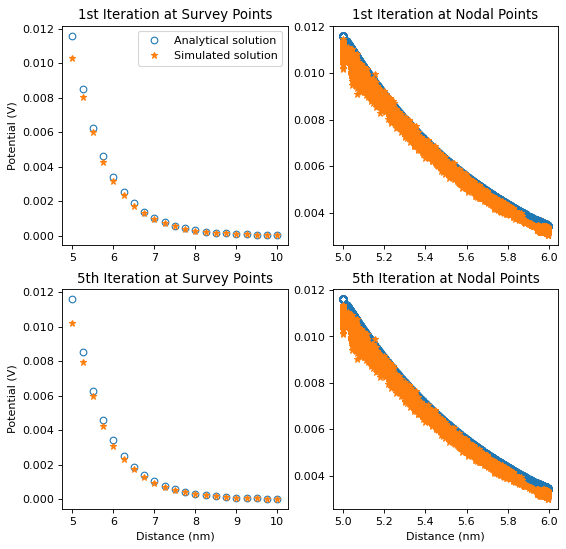

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#analytical solution to 1D linear PB equation for spherical coordinate
def an_sol(x,a,rel_perm,tK,cinf,zval,zeta,gradflag=0):
    echarge=1.602e-19 #elementary charge [C]
    perm0=8.85e-12 #vacuum permittivity [F/m]
    kB=1.381e-23 #Boltzmann's constant [J/K]
    kA=6.022e23 #Avogadro constant [1/mol]

    debye_len=np.sqrt(perm0*rel_perm*kB*tK/2/(zval*echarge)**2/kA/cinf)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    
    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm
    
    u=zeta*a*np.exp((a-x)/debye_len)/x
    return u

data=np.loadtxt('sphere_s21.01')
dist=np.abs(data[:,1])
ua=an_sol(dist,a=5e-9,rel_perm=78.5,tK=298,cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,2,sharey=False,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(dist*1e9,ua,'o',markerfacecolor='none')
axs[0].plot(dist*1e9,data[:,5],'*')
axs[0].legend(['Analytical solution','Simulated solution'])
axs[0].set_ylabel('Potential (V)')
axs[0].set_title('1st Iteration at Survey Points')

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)/kd
mask=(dist>5e-9)&(dist<6e-9)
ua=an_sol(dist,a=5e-9,rel_perm=78.5,tK=298,cinf=100,zval=1,zeta=0.01,gradflag=1)

axs[1].plot(dist[mask]*1e9,ua[mask],'o',markerfacecolor='none')
axs[1].plot(dist[mask]*1e9,u0[mask],'*')
axs[1].set_title('1st Iteration at Nodal Points')

data=np.loadtxt('sphere_s21.05')
dist=np.abs(data[:,1])
ua=an_sol(dist,a=5e-9,rel_perm=78.5,tK=298,cinf=100,zval=1,zeta=0.01,gradflag=1)

axs[2].plot(dist*1e9,ua,'o',markerfacecolor='none')
axs[2].plot(dist*1e9,data[:,5],'*')
axs[2].set_xlabel('Distance (nm)')
axs[2].set_ylabel('Potential (V)')
axs[2].set_title('5th Iteration at Survey Points')

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)/kd
mask=(dist>5e-9)&(dist<6e-9)
ua=an_sol(dist,a=5e-9,rel_perm=78.5,tK=298,cinf=100,zval=1,zeta=0.01,gradflag=1)

axs[3].plot(dist[mask]*1e9,ua[mask],'o',markerfacecolor='none')
axs[3].plot(dist[mask]*1e9,u[mask],'*')
axs[3].set_xlabel('Distance (nm)')
axs[3].set_title('5th Iteration at Nodal Points')

# ax[1].set_yscale('log')
plt.show()
